## CE9010 Introduction to Data Science Project

# Data Scraper



First, we import the relevant libraries.

In [121]:
from bs4 import Comment, BeautifulSoup as bs
import urllib.request
import csv
import traceback
import numpy as np
import pandas as pd
import sys

%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from copy import copy
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# TO BE FORMATTED \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


Data Acquisition
 ------

#### Warning, long runtime of up to 40 minutes. Program will finish scraping when END OF YEAR: 2016 is printed.

Scraper written in beautifulsoup.

#### Types of data extracted
---

Our main goal of our is to predict the impact of college prospects in the first and second year of NBA based on their college stats. Hence we choose to use their advanced stats available in college (ws, ws/40min) to generalize the impact on NBA measured in their advanced stats available in the NBA (per, ws, ws/48, bpm, vorp) for their first two years in the league. We chose to extract data from 1996 as college advanced statistics were only available from the 1995 season onwards. We also chose to only include the first 30 draft picks of each draft as players beyond the 30th picks usually do not play significant minutes in their teams.

Player's NBA stats extracted from [Basketball Reference](https://www.basketball-reference.com/).

Player's College stats extracted from [Sports Reference](https://www.sports-reference.com/)

---



#### Problems encountered

---

The main problem encountered when running the scraper is the long runtime for a relatively small dataset est <200? confirm again>. The bottleneck occurs when parsing the whole page to look for the link to the sports reference website for each player in order to acquire their respective college stats. Having to parse the whole page for every player leads to a long runtime; inefficient code. A better solution would be to use another data scraping framework such as Scrapy which allows data extraction using [selectors](https://doc.scrapy.org/en/latest/topics/selectors.html). Extracting the link to sports-reference website of the page using the XPath or CSS selector would be much quicker than parsing the entire page. However as this scraper would only need to be run once it is not a major concern to optimize and rewrite another scraper.

## Utility functions

In [3]:


def extract_comments(inside_html, html_id):
    comments = inside_html.findAll(text=lambda text:isinstance(text, Comment)) #data we want is commented, hence the need 
    comments = [comment.extract() for comment in comments if 'id=\"' + html_id + '\"' in comment.extract()] #get advanced stats table
    return bs(comments[0], 'html.parser')

def read_url_into_soup(url):
    try:
        next_page = urllib.request.urlopen(url).read() # goes to player page
        return bs(next_page, 'html.parser')
    except:
        traceback.print_exc()
        return read_url_into_soup(url)

## Main

In [5]:
f = open("data/nba_all.csv", "w")
f2 = open("data/college_all.csv", "w")
writer = csv.writer(f)
writerf = csv.writer(f2)    
running = False
# year_dict = {}

for year in range(1996, 2017):
    url = "https://www.basketball-reference.com/draft/NBA_"+ str(year) + ".html"
#     req = urllib.request.Request(url)
#     html = read_url_into_soup(req)
    html = read_url_into_soup(url)
#     response = urllib.request.urlopen(req)
#     html = response.read()
#     html = bs(html, 'html.parser')
    if running:
        break
    
    for row in html.table.tbody.findAll("tr"):

        if (row.find("td")) is None:
            print("END OF YEAR: "+ str(year) +"\n")  # reach end of file
            break
            
        seasons = row.find("td", {"data-stat" : "seasons"} )
        
        if (not seasons.get_text() or  #if player did not play in NBA after being drafted
        int(seasons.get_text()) < 2 or  # if less than 2 seasons played, skip
        len(row.find("td", {"data-stat" : "college_name"}) ) < 1): #if player played in euroleague
            continue
            
        player = row.find("td",{"data-stat" : "player"})
        print(player.get_text())
        inside_html = read_url_into_soup("https://www.basketball-reference.com/" + player.a['href'])
#         next_page = urllib.request.urlopen("https://www.basketball-reference.com/" + player.a['href']).read() # goes to player page
#         inside_html = bs(next_page, 'html.parser')
        
        advanced = extract_comments(inside_html, 'advanced')
        
        # STATS
          
        out = [player.string]
        cols = ['per', 'ws_per_48', 'bpm', 'vorp'] # stats to include
        for col in cols:
            out.append(advanced.findAll('td', {'data-stat' : col})[0].string) #include both 1st and 2nd year
            out.append(advanced.findAll('td', {'data-stat' : col})[1].string) 
        out.append(year)
        writer.writerow(out)
        
        for i in inside_html.findAll("a"): #inefficient way of finding the url for college stats
            if "College Basketball" in str(i):
                coll_url = i['href']
                break
              
        coll_html = read_url_into_soup(coll_url)
#         coll_page = urllib.request.urlopen(coll_url).read()
#         coll_html = bs(coll_page, 'html.parser')

        
        coll_advanced = extract_comments(coll_html, 'players_advanced')
        coll_html = read_url_into_soup(coll_url)
        coll_players_pm = extract_comments(coll_html, 'players_per_min')
        
        
        cols = ['g','gs','fg_per_min','fga_per_min','fg_pct','fg2_per_min','fg2a_per_min','fg2_pct','fg3_per_min',
                'fg3a_per_min','fg3_pct','ft_per_min','fta_per_min','ft_pct','trb_per_min','ast_per_min', 'stl_per_min',
                'blk_per_min', 'tov_per_min','pf_per_min','pts_per_min']

        pm = [coll_players_pm.tbody.findAll('td', {'data-stat' : c})[-1].string for c in cols]
        
        #input stats
        cols = ["mp", "ts_pct","efg_pct","fg3a_per_fga_pct", "fta_per_fga_pct","ws_per_40"]
#         for col in cols:
#         ws40 = coll_advanced.tbody.findAll('td', {'data-stat' : 'ws_per_40'})[-1].string
        adv = [coll_advanced.tbody.findAll('td', {'data-stat' : c})[-1].string for c in cols]
        
        sos = coll_html.findAll('td', {'data-stat' : 'sos'})[-2].string
        result = [player.string, sos, year]
        result.extend(adv)
        result.extend(pm)
#         print(result)
        writerf.writerow(result)
#         running = True
#         break
            
f.close()
f2.close()    

Allen Iverson
Marcus Camby
Shareef Abdur-Rahim
Stephon Marbury
Ray Allen
Antoine Walker
Lorenzen Wright
Kerry Kittles
Samaki Walker
Erick Dampier
Todd Fuller
Vitaly Potapenko
Steve Nash
Tony Delk
John Wallace
Walter McCarty
Roy Rogers
Derek Fisher
Jerome Williams
Brian Evans
Priest Lauderdale
Travis Knight
END OF YEAR: 1996

Tim Duncan
Keith Van Horn
Chauncey Billups
Antonio Daniels
Tony Battie
Ron Mercer
Tim Thomas
Adonal Foyle
Danny Fortson
Tariq Abdul-Wahad
Austin Croshere
Derek Anderson
Maurice Taylor
Kelvin Cato
Brevin Knight
Johnny Taylor
Scot Pollard
Paul Grant
Anthony Parker
Ed Gray
Bobby Jackson
Rodrick Rhodes
John Thomas
Charles Smith
Jacque Vaughn
Keith Booth
END OF YEAR: 1997

Michael Olowokandi
Mike Bibby
Raef LaFrentz
Antawn Jamison
Vince Carter
Robert Traylor
Jason Williams
Larry Hughes
Paul Pierce
Bonzi Wells
Michael Doleac
Keon Clark
Michael Dickerson
Matt Harpring
Bryce Drew
Pat Garrity
Roshown McLeod
Ricky Davis
Brian Skinner
Tyronn Lue
Felipe Lopez
Sam Jacobson
Core

Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1260, in connect
    server_hostname=server_hostname)
  File "/usr/lib/python3.5/ssl.py", line 377, in wrap_socket
    _context=self)
  File "/usr/lib/python3.5/ssl.py", line 752, in __init__
    self.do_handshake()
  File "/usr/lib/python3.5/ssl.py", line 988, in do_handshake
    self._sslo

Jerome Moiso
Etan Thomas
Courtney Alexander
Mateen Cleaves
Jason Collier
Desmond Mason
Quentin Richardson
Jamaal Magloire
Speedy Claxton
Morris Peterson
Donnell Harvey
Mamadou N'Diaye
Erick Barkley
Mark Madsen
END OF YEAR: 2000

Jason Richardson
Shane Battier
Eddie Griffin
Rodney White
Joe Johnson
Kedrick Brown
Richard Jefferson
Troy Murphy
Steven Hunter
Kirk Haston
Michael Bradley
Jason Collins
Zach Randolph
Brendan Haywood
Joseph Forte
Jeryl Sasser
Brandon Armstrong
Gerald Wallace
Samuel Dalembert
Jamaal Tinsley
END OF YEAR: 2001

Mike Dunleavy
Drew Gooden
Dajuan Wagner
Chris Wilcox
Caron Butler
Jared Jeffries
Melvin Ely
Marcus Haislip
Fred Jones
Juan Dixon
Curtis Borchardt
Ryan Humphrey
Kareem Rush
Qyntel Woods
Casey Jacobsen
Tayshaun Prince
Frank Williams
John Salmons
Chris Jefferies
Dan Dickau
END OF YEAR: 2002

Carmelo Anthony
Chris Bosh
Dwyane Wade
Chris Kaman
Kirk Hinrich
T.J. Ford
Mike Sweetney
Jarvis Hayes
Nick Collison
Marcus Banks
Luke Ridnour
Reece Gaines
David West
Dahnta

Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


Traceback (most recent call last):
  File "/usr/lib/python3.5/urllib/request.py", line 1254, in do_open
    h.request(req.get_method(), req.selector, req.data, headers)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 1151, in _send_request
    self.endheaders(body)
  File "/usr/lib/python3.5/http/client.py", line 1102, in endheaders
    self._send_output(message_body)
  File "/usr/lib/python3.5/http/client.py", line 934, in _send_output
    self.send(msg)
  File "/usr/lib/python3.5/http/client.py", line 877, in send
    self.connect()
  File "/usr/lib/python3.5/http/client.py", line 1252, in connect
    super().connect()
  File "/usr/lib/python3.5/http/client.py", line 849, in connect
    (self.host,self.port), self.timeout, self.source_address)
  File "/usr/lib/python3.5/socket.py", line 693, in create_connection
    for res in getaddrinfo(host, port, 0, SOCK_STREAM):


END OF YEAR: 2005

LaMarcus Aldridge
Adam Morrison
Tyrus Thomas
Shelden Williams
Brandon Roy
Randy Foye
Rudy Gay
Patrick O'Bryant
J.J. Redick
Hilton Armstrong
Ronnie Brewer
Cedric Simmons
Rodney Carney
Shawne Williams
Quincy Douby
Renaldo Balkman
Rajon Rondo
Marcus Williams
Josh Boone
Kyle Lowry
Shannon Brown
Jordan Farmar
Maurice Ager
Mardy Collins
END OF YEAR: 2006

Greg Oden
Kevin Durant
Al Horford
Mike Conley
Jeff Green
Corey Brewer
Brandan Wright
Joakim Noah
Spencer Hawes
Acie Law
Thaddeus Young
Julian Wright
Al Thornton
Rodney Stuckey
Nick Young
Sean Williams
Javaris Crittenton
Jason Smith
Daequan Cook
Jared Dudley
Wilson Chandler
Morris Almond
Aaron Brooks
Arron Afflalo
Alando Tucker
END OF YEAR: 2007

Derrick Rose
Michael Beasley
O.J. Mayo
Russell Westbrook
Kevin Love
Eric Gordon
Joe Alexander
D.J. Augustin
Brook Lopez
Jerryd Bayless
Jason Thompson
Brandon Rush
Anthony Randolph
Robin Lopez
Marreese Speights
Roy Hibbert
JaVale McGee
J.J. Hickson
Ryan Anderson
Courtney Lee
Kosta 

## ML SHIT HERE
#### We used college_all and nba_all outside the data/ directory in case we accidentally ran the above function and everything is overwritten

- remove rows with NaN (somehow in 1997-1998 some college statistics were not recorded)

In [57]:
college_df = pd.read_csv('college_all.csv')
college_df.isnull().sum() #check for missing data
college_df.columns = ["Player","sos", "year","mp", "ts_pct","efg_pct","3pt_ar", "fta_per_fga","ws_per_40",
                      'g','gs','fg_per_min','fga_per_min','fg_pct','fg2_per_min','fg2a_per_min','fg2_pct','fg3_per_min',
                      'fg3a_per_min','fg3_pct','ft_per_min','fta_per_min','ft_pct','trb_per_min','ast_per_min',
                      'stl_per_min','blk_per_min', 'tov_per_min','pf_per_min','pts_per_min']
college_df = college_df.drop(columns = ['gs']) #remove column with many empty cells

nba_df = pd.read_csv('nba_all.csv', header=None)
nba_df.columns = ['Player','PER 1st', 'PER 2nd', 'WS48 1st','WS48 2nd',
                  'BPM 1st', 'BPM 2nd','VORP 1st', 'VORP 2nd', 'year']

nba_df = nba_df.drop(['year'], axis=1) #remove duplicate column


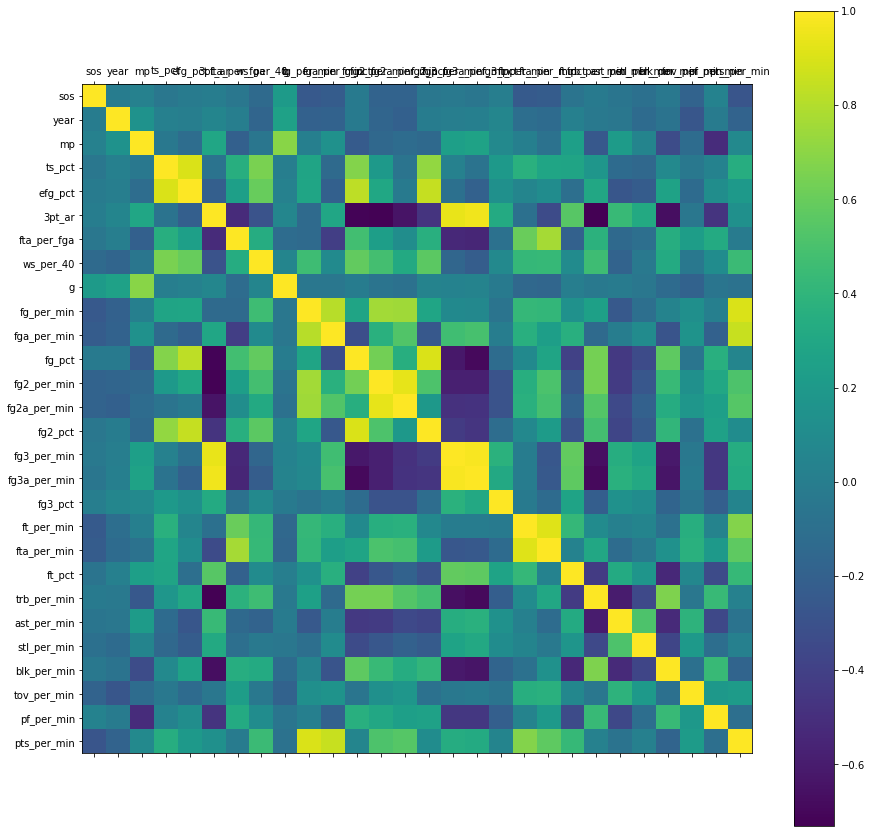

In [58]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
plot_corr(college_df, 15)
#drop all high correlations and negative



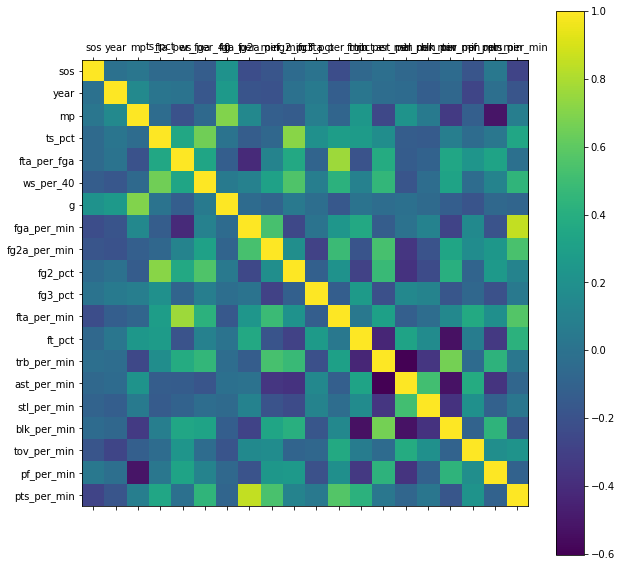

In [59]:
#after removing high correlations
college_df = college_df.drop(columns = ['3pt_ar','efg_pct','fg3_per_min','fg3a_per_min','ft_per_min',
                                         'fg2_per_min','fg_per_min','fg_pct'])
plot_corr(college_df, 10)

In [60]:
comb = pd.merge(nba_df, college_df, on=['Player', 'Player'])

print(comb.shape)
print("Number of rows to remove =",college_df[college_df.isnull().any(axis=1)].shape[0]) #amount of data to remove
comb = comb.dropna(how = 'any').drop(columns = ['Player']) #remove rows with NaN
print(comb.shape)
print("Are there any rows with empty cells?", comb.isnull().values.any() )
comb.head()


(485, 29)
Number of rows to remove = 85
(400, 28)
Are there any rows with empty cells? False


PER 1st  PER 2nd  WS48 1st  WS48 2nd  BPM 1st  BPM 2nd  VORP 1st  VORP 2nd  \
0     17.8     15.9     0.095     0.022     -0.3     -0.7       0.8       0.7   
1     17.4     21.1     0.049     0.113     -2.0      1.2       0.0       2.3   
2     16.1     16.3     0.077     0.082     -1.0     -0.6       0.6       1.1   
3     14.6     16.2     0.092     0.102      0.3      1.8       1.5       3.2   
4     15.5     17.8     0.027     0.070     -1.0      0.7       0.8       2.2   

     sos  year     ...       fg3_pct  fta_per_min  ft_pct  trb_per_min  \
0   8.92  1996     ...         0.000          9.2   0.700         10.7   
1   6.44  1996     ...         0.381         10.2   0.683          9.7   
2  12.71  1996     ...         0.370          4.9   0.738          3.4   
3   8.19  1996     ...         0.466          5.4   0.810          8.3   
4  10.06  1996     ...         0.188          5.4   0.631         12.4   

   ast_per_min  stl_per_min  blk_per_min  tov_per_min  pf_per_min  pts_per_min  
0          2.3          1.3          5.1          3.3         3.4         26.7  
1          1.2          2.1          1.4          3.6         2.4         24.3  
2          4.8          1.9          0.1          3.4         2.4         20.2  
3          4.3          2.2          0.7          3.0         1.7         29.8  
4          4.3          2.5          1.0          3.7         3.5         22.5  

[5 rows x 28 columns]

# train test split

In [123]:
 #enter favourite number
seed = 100



def split_val_set(y_var, no_of_set, X):
    '''
    SPLITS SET INTO VAL AND TRAINING SETS and test set
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, comb[y_var], test_size=0.20, random_state=seed)

    splits_x = []
    splits_y = []
    no_of_set = 4
    size_set = int(len(X_train) / no_of_set)
    for i in range(0, no_of_set - 1):
        split_set_x = X_train[size_set * i : size_set * (i+1)] #split first 3 evenly
        split_set_y = y_train[size_set * i : size_set * (i+1)]
        splits_x.append(split_set_x)
        splits_y.append(split_set_y)
    splits_x.append(X_train[size_set*3:]) 
    splits_y.append(y_train[size_set*3:])
    
    return splits_x, splits_y, X_test, y_test

def split_val_set_2(Y, no_of_set, X):
    '''
    SPLITS SET INTO VAL AND TRAINING SETS and test set
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)

    splits_x = []
    splits_y = []
    no_of_set = 4
    size_set = int(len(X_train) / no_of_set)
    for i in range(0, no_of_set - 1):
        split_set_x = X_train[size_set * i : size_set * (i+1)] #split first 3 evenly
        split_set_y = y_train[size_set * i : size_set * (i+1)]
        splits_x.append(split_set_x)
        splits_y.append(split_set_y)
    splits_x.append(X_train[size_set*3:]) 
    splits_y.append(y_train[size_set*3:])
    
    return splits_x, splits_y, X_test, y_test

def merge_train(i, xset, yset):
    '''
    merge training sets for each k iteration
    '''
    to_merge_x = [val for index, val in enumerate(xset) if index != i]
    to_merge_y = [val for index, val in enumerate(yset) if index != i]
    return pd.concat(to_merge_x), pd.concat(to_merge_y)

# MAIN\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\ :DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
normalize : boolean, optional, default False

This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm. If you wish to standardize, please use sklearn.preprocessing.StandardScaler before calling fit on an estimator with normalize=False.

Code below finds the best hyper parameter D for each Y parameter.
d = 3 


PER 1st
PER 1st
PER 1st
PER 1st


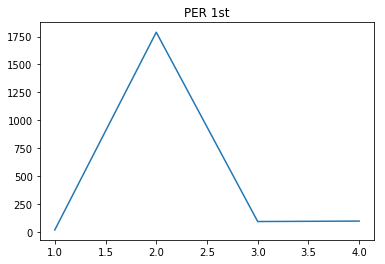

[16.37462537217756, 1788.9056806763565, 91.58857999867102, 95.52008044068285]
[13.273078118177239, 0.7000865398324209, 0.06074999999999999, 0.06074999999999999]
PER 2nd
PER 2nd
PER 2nd
PER 2nd


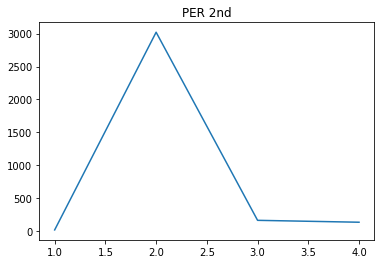

[20.191915330195307, 3020.601590569012, 165.67345036902896, 136.8678372841736]
[17.391049356427754, 0.7203425187438424, 0.0020833333333333333, 0.0020833333333333333]
WS48 1st
WS48 1st
WS48 1st
WS48 1st


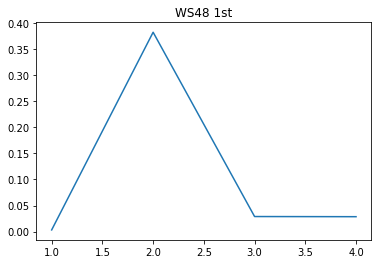

[0.0031685267500467865, 0.3827934984086096, 0.0288602527514616, 0.02855901003387674]
[0.002946258640076286, 0.000150641861691411, 9.352083333333333e-06, 9.352083333333335e-06]
WS48 2nd
WS48 2nd
WS48 2nd
WS48 2nd


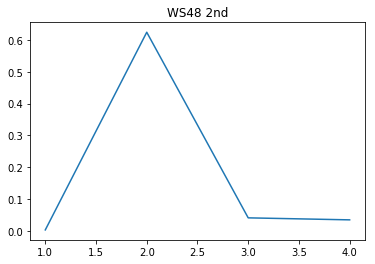

[0.0036341229157060622, 0.6239648437713682, 0.04149931610383738, 0.0352007096210221]
[0.003737535154670205, 0.00017418554741421225, 9.633333333333333e-06, 9.633333333333333e-06]
BPM 1st
BPM 1st
BPM 1st
BPM 1st


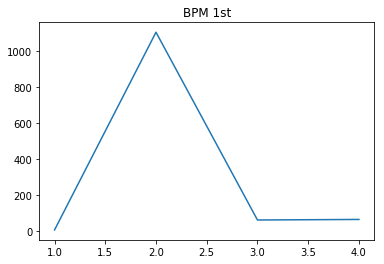

[7.95915417243189, 1104.7289194458904, 63.02649062434633, 66.06638223984687]
[6.992293024134471, 0.5664193940396853, 0.010083333333333335, 0.010083333333333335]
BPM 2nd
BPM 2nd
BPM 2nd
BPM 2nd


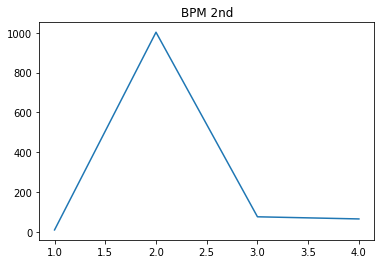

[8.784965612261333, 1002.6502322628343, 74.77573643178172, 63.996647078753696]
[8.272971110525328, 0.5155279078476319, 0.011020833333333332, 0.011020833333333332]
VORP 1st
VORP 1st
VORP 1st
VORP 1st


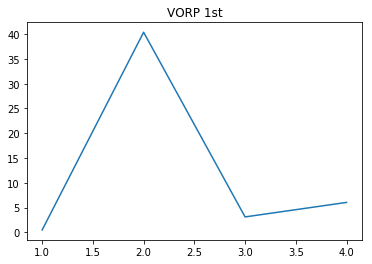

[0.5055819558688975, 40.3688567800802, 3.125685435163468, 6.049855489857352]
[0.5933951198869637, 0.02849608442627057, 0.00020833333333333335, 0.00020833333333333335]
VORP 2nd
VORP 2nd
VORP 2nd
VORP 2nd


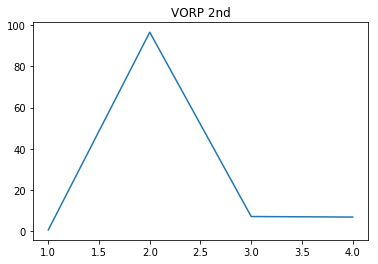

[0.7281364340697333, 96.44871858129646, 7.212937018018579, 6.944855110275182]
[1.0564298496773303, 0.05406324401947998, 0.0001875, 0.0001875]


In [120]:
no_of_set = 4 #NO OF K 
for y_name in list(nba_df.drop(columns=['Player'])):
    thing = []
    thing2 = []
    for D in range(1,5):
        poly = PolynomialFeatures(D)
        print(y_name)
        X = comb.iloc[:,8:]
        X = poly.fit_transform(X)
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        xset , yset, x_test, y_test = split_val_set(y_name, no_of_set, pd.DataFrame(X))
    #     x_test = poly.fit_transform(x_test)
        min_mse = float('inf')
        min_mse_train = float('inf')

        for i in range(no_of_set):
            x_valid = xset[i]
    #         x_valid = poly.fit_transform(xset[i])
            y_valid = yset[i]
            x_train, y_train = merge_train(i, xset, yset)
    #         x_train = poly.fit_transform(x_train)
            lin_reg_sklearn = LinearRegression() #normalize according to z


            lin_reg_sklearn.fit(x_train, y_train)

    #         y_pred = [float(lin_reg_sklearn.predict(x)) for x in np.asarray(x_valid)]
            y_pred = lin_reg_sklearn.predict(x_valid)
        
            mse = mean_squared_error((y_valid), y_pred)
            
            y_pred_train = lin_reg_sklearn.predict(x_train)
        
            mse_train = mean_squared_error((y_train), y_pred_train)
            if min_mse > mse:
                min_mse = mse
                best_model = copy(lin_reg_sklearn)
            if min_mse_train > mse_train:
                min_mse_train = mse_train
                
        thing.append(min_mse)
        thing2.append(min_mse_train)
    plt.plot(range(1,len(thing)+1), thing)
    plt.title(y_name)
    plt.show()
    print(thing)
    print(thing2)
    
    


VORP 2nd
VORP 2nd
VORP 2nd
VORP 2nd


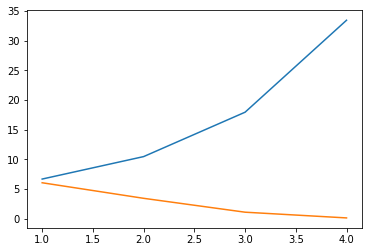

[6.660524642417643, 10.44530255758805, 17.927750092547697, 33.42661555962671]
[6.03602559760677, 3.414590833926003, 1.0748901728157079, 0.11032094085734728]


In [125]:
no_of_set = 4 #NO OF K 
# for y_name in list(nba_df.drop(columns=['Player'])):
thing = []
thing2 = []
for D in range(1,5):
    poly = PolynomialFeatures(D)
    print(y_name)
    X = comb.iloc[:,8:]
    X = poly.fit_transform(X)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Y = comb.iloc[:,:8]
    xset , yset, x_test, y_test = split_val_set_2(Y, no_of_set, pd.DataFrame(X))
#     x_test = poly.fit_transform(x_test)
    min_mse = float('inf')
    min_mse_train = float('inf')

    for i in range(no_of_set):
        x_valid = xset[i]
#         x_valid = poly.fit_transform(xset[i])
        y_valid = yset[i]
        x_train, y_train = merge_train(i, xset, yset)
#         x_train = poly.fit_transform(x_train)
        lin_reg_sklearn = Ridge() #normalize according to z


        lin_reg_sklearn.fit(x_train, y_train)

#         y_pred = [float(lin_reg_sklearn.predict(x)) for x in np.asarray(x_valid)]
        y_pred = lin_reg_sklearn.predict(x_valid)

        mse = mean_squared_error((y_valid), y_pred)

        y_pred_train = lin_reg_sklearn.predict(x_train)

        mse_train = mean_squared_error((y_train), y_pred_train)
        if min_mse > mse:
            min_mse = mse
            best_model = copy(lin_reg_sklearn)
        if min_mse_train > mse_train:
            min_mse_train = mse_train

    thing.append(min_mse)
    thing2.append(min_mse_train)
plt.plot(range(1,len(thing)+1), thing)
plt.plot(range(1,len(thing2)+1), thing2)
plt.show()
print(thing)
print(thing2)
    
    


# RECIPE TO FOLLOW

## Pre process (zero mean? unit variance?)
## Extract a subset of training data and over fit them? L train close to zero and Lval high by manually selecting hyper par
## Add regularization and evaluate the generalization performance on the validation set
## Lval and L train gap should be minimized and both be ideally small
## USe all training data and cross validation to estimate the parameters and hyper parameters 

    

In [13]:
import statsmodels.api as sm

X = sm.add_constant(poly.fit_transform(comb.iloc[:,8:]))
Y = comb['WS48 1st']
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               WS48 1st   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                 -1.733
Method:                 Least Squares   F-statistic:                    0.3546
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.993
Time:                        23:03:47   Log-Likelihood:                 1147.3
No. Observations:                 400   AIC:                            -1509.
Df Residuals:                       7   BIC:                             60.14
Df Model:                         392                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.153e-08    8.1e-09     -1.423      0.198   -3.07e-08    7.63e-09
x1          8.854e-07   1.11e-06      0.799      0.450   -1.73e-06     3.5e-06
x2         -7.323e-06   5.26e-06     -1.392      0.206   -1.98e-05    5.11e-06
x3         -4.067e-06    2.9e-06     -1.402      0.204   -1.09e-05    2.79e-06
x4         -4.493e-08   6.03e-08     -0.745      0.481   -1.88e-07    9.77e-08
x5          -1.14e-07   8.52e-08     -1.339      0.223   -3.15e-07    8.74e-08
x6          3.657e-08    9.6e-08      0.381      0.714    -1.9e-07    2.63e-07
x7          4.893e-07    9.9e-07      0.494      0.636   -1.85e-06    2.83e-06
x8          1.153e-06   1.12e-06      1.029      0.338    -1.5e-06     3.8e-06
x9         -4.061e-07   9.13e-07     -0.445      0.670   -2.56e-06    1.75e-06
x10        -3.739e-08   9.29e-08     -0.403      0.699   -2.57e-07    1.82e-07
x11         3.388e-08   1.09e-07      0.310      0.766   -2.25e-07    2.92e-07
x12        -5.682e-07   1.05e-06     -0.540      0.606   -3.06e-06    1.92e-06
x13           4.4e-09   1.09e-07      0.040      0.969   -2.53e-07    2.62e-07
x14         8.087e-07   1.14e-06      0.710      0.500   -1.88e-06     3.5e-06
x15         2.763e-07   1.16e-06      0.238      0.819   -2.47e-06    3.02e-06
x16        -2.121e-07   1.11e-06     -0.191      0.854   -2.83e-06    2.41e-06
x17        -8.176e-07   1.02e-06     -0.800      0.450   -3.24e-06     1.6e-06
x18         -4.36e-07   1.05e-06     -0.413      0.692   -2.93e-06    2.06e-06
x19         1.407e-07   9.83e-07      0.143      0.890   -2.18e-06    2.46e-06
x20        -2.413e-07    1.1e-06     -0.219      0.833   -2.84e-06    2.36e-06
x21          3.26e-06   1.49e-05      0.219      0.833   -3.19e-05    3.84e-05
x22            0.0009      0.001      0.826      0.436      -0.002       0.004
x23            0.0003      0.001      0.616      0.557      -0.001       0.002
x24          2.14e-07   5.36e-07      0.399      0.702   -1.05e-06    1.48e-06
x25        -4.747e-07   5.62e-07     -0.844      0.426    -1.8e-06    8.55e-07
x26         1.553e-07   5.15e-07      0.302      0.772   -1.06e-06    1.37e-06
x27         1.309e-05   1.84e-05      0.711      0.500   -3.04e-05    5.66e-05
x28         9.759e-06   1.21e-05      0.809      0.445   -1.88e-05    3.83e-05
x29        -2.648e-06   8.97e-06     -0.295      0.776   -2.38e-05    1.86e-05
x30         2.265e-07   5.26e-07      0.431      0.680   -1.02e-06    1.47e-06
x31         5.188e-07   5.62e-07      0.923      0.387    -8.1e-07    1.85e-06
x32         5.087e-08   5.47e-06      0.009      0.993   -1.29e-05     1.3e-05
x33         2.206e-07   7.05e-07      0.313      0.763   -1.45e-06    1.89e-06
x34         1.202e-06   9.43e-06      0.127      0.902   -2.11e-05    2.35e-05
x35         3.916e-06   6.57e-06      0.596      0.570   -1.16e-05    1.95e-05
x3

In [38]:
lin_reg_sklearn = LinearRegression() #normalize according to z

poly = PolynomialFeatures(5)
X = comb.iloc[:,8:]
X = poly.fit_transform(X)
# min_mse = float('inf')
Y = comb['WS48 1st']
X_train, X_test, y_train, y_test = train_test_split(X, Y)
lin_reg_sklearn.fit(X_train, y_train)

#         y_pred = [float(lin_reg_sklearn.predict(x)) for x in np.asarray(x_valid)]
print(mean_squared_error(np.asarray(y_test), lin_reg_sklearn.predict(X_test)))
print("R-squared:", lin_reg_sklearn.score(X_test, y_test))
#     plt.plot(best_model)
    

0.19153674356755815
R-squared: -41.63609224323307
